In [3]:
%matplotlib inline

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import scanpy as sc
from scipy import sparse

import sys
sys.path.append('/home/ngr4/project/')
from scnd.scripts import data as scnddata
from scnd.scripts import utils as scndutils


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [4]:
adata = scnddata.load_mouse()
pfp = '/home/ngr4/project/scnd/results/'

In [5]:
# aesthetics
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(5)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 1915 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 1.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.47 seconds.
Calculated PHATE in 6.92 seconds.


running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 598 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 0.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.25 seconds.
Calculated PHATE in 0.40 seconds.
Calculating PHATE...
  Running PHATE on 1915 observations and 26374 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.16 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.47 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 4.67 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 1.59 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seco

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 320 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.07 seconds.
Calculated PHATE in 0.11 seconds.


running Leiden clustering
    finished (0:00:00)
computing UMAP
    finished (0:00:01)


Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 321 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.07 seconds.
Calculated PHATE in 0.11 seconds.
Calculating PHATE...
  Running PHATE on 320 observations and 26374 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.71 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.74 seconds.
  Calculating optimal t...
    Automatically selected t = 7
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.04 seconds.
Calculated PHATE in 0.82 seconds.
Calculating PHATE...
  Running PHATE 

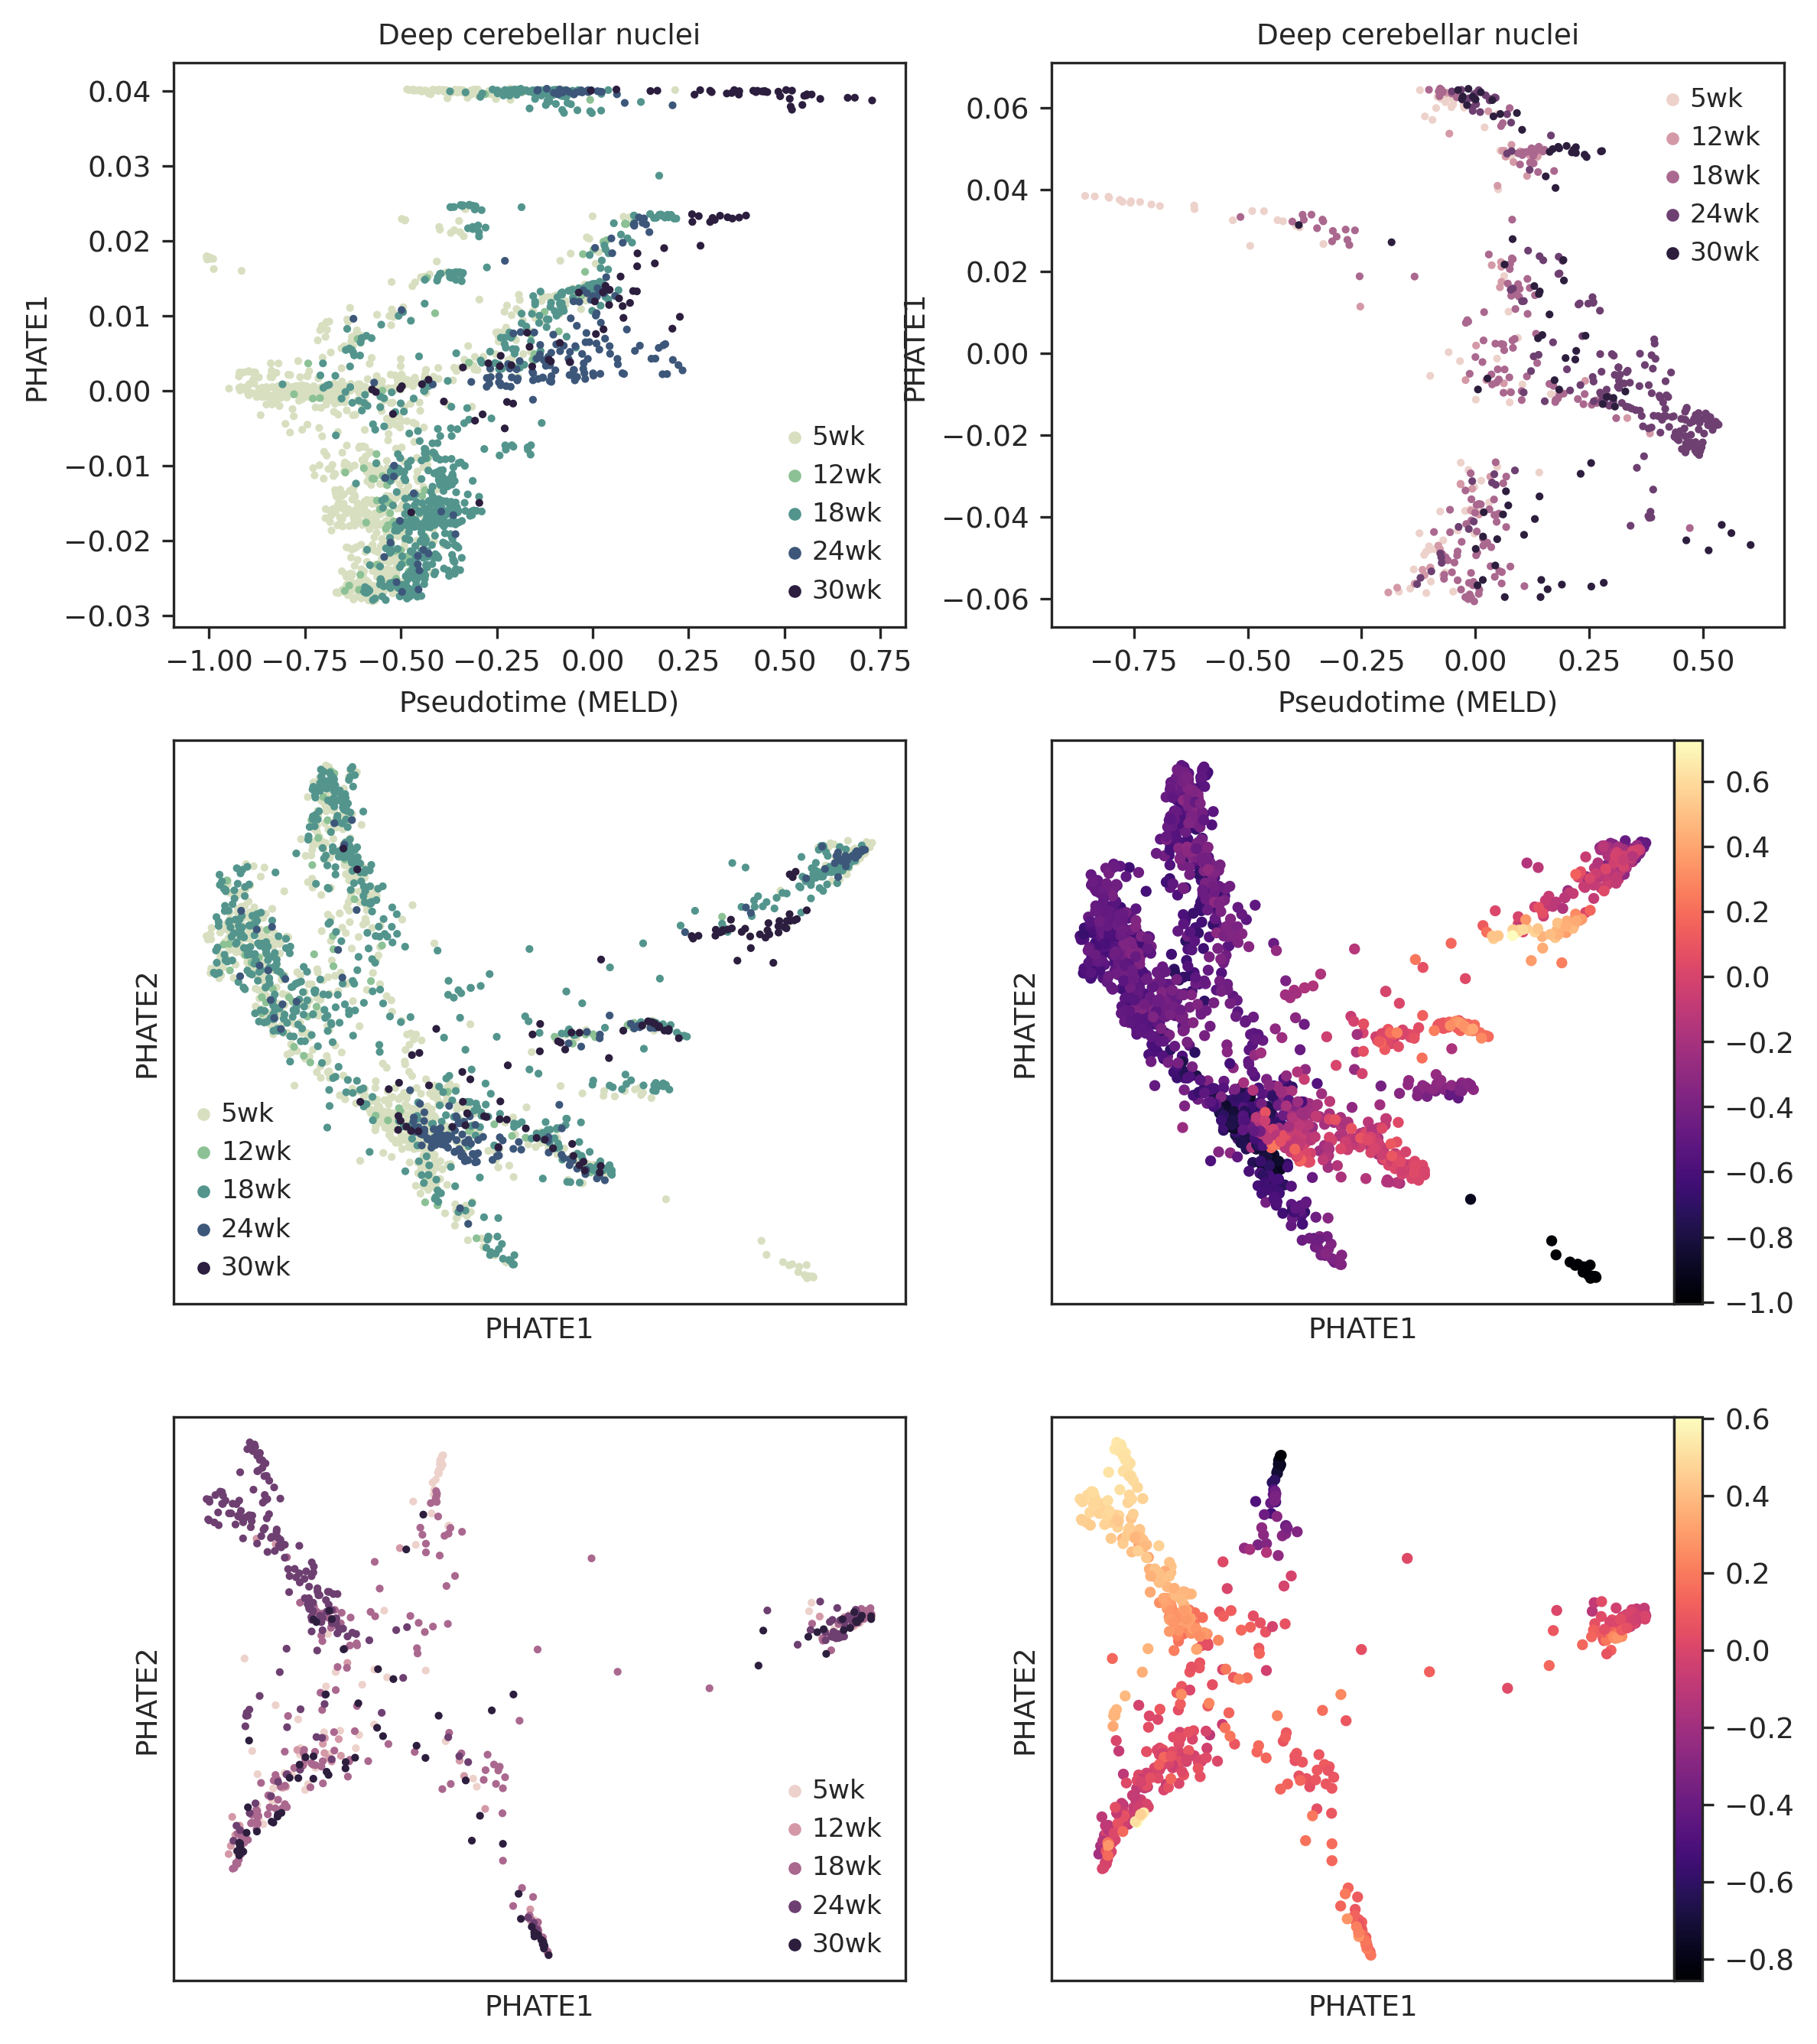

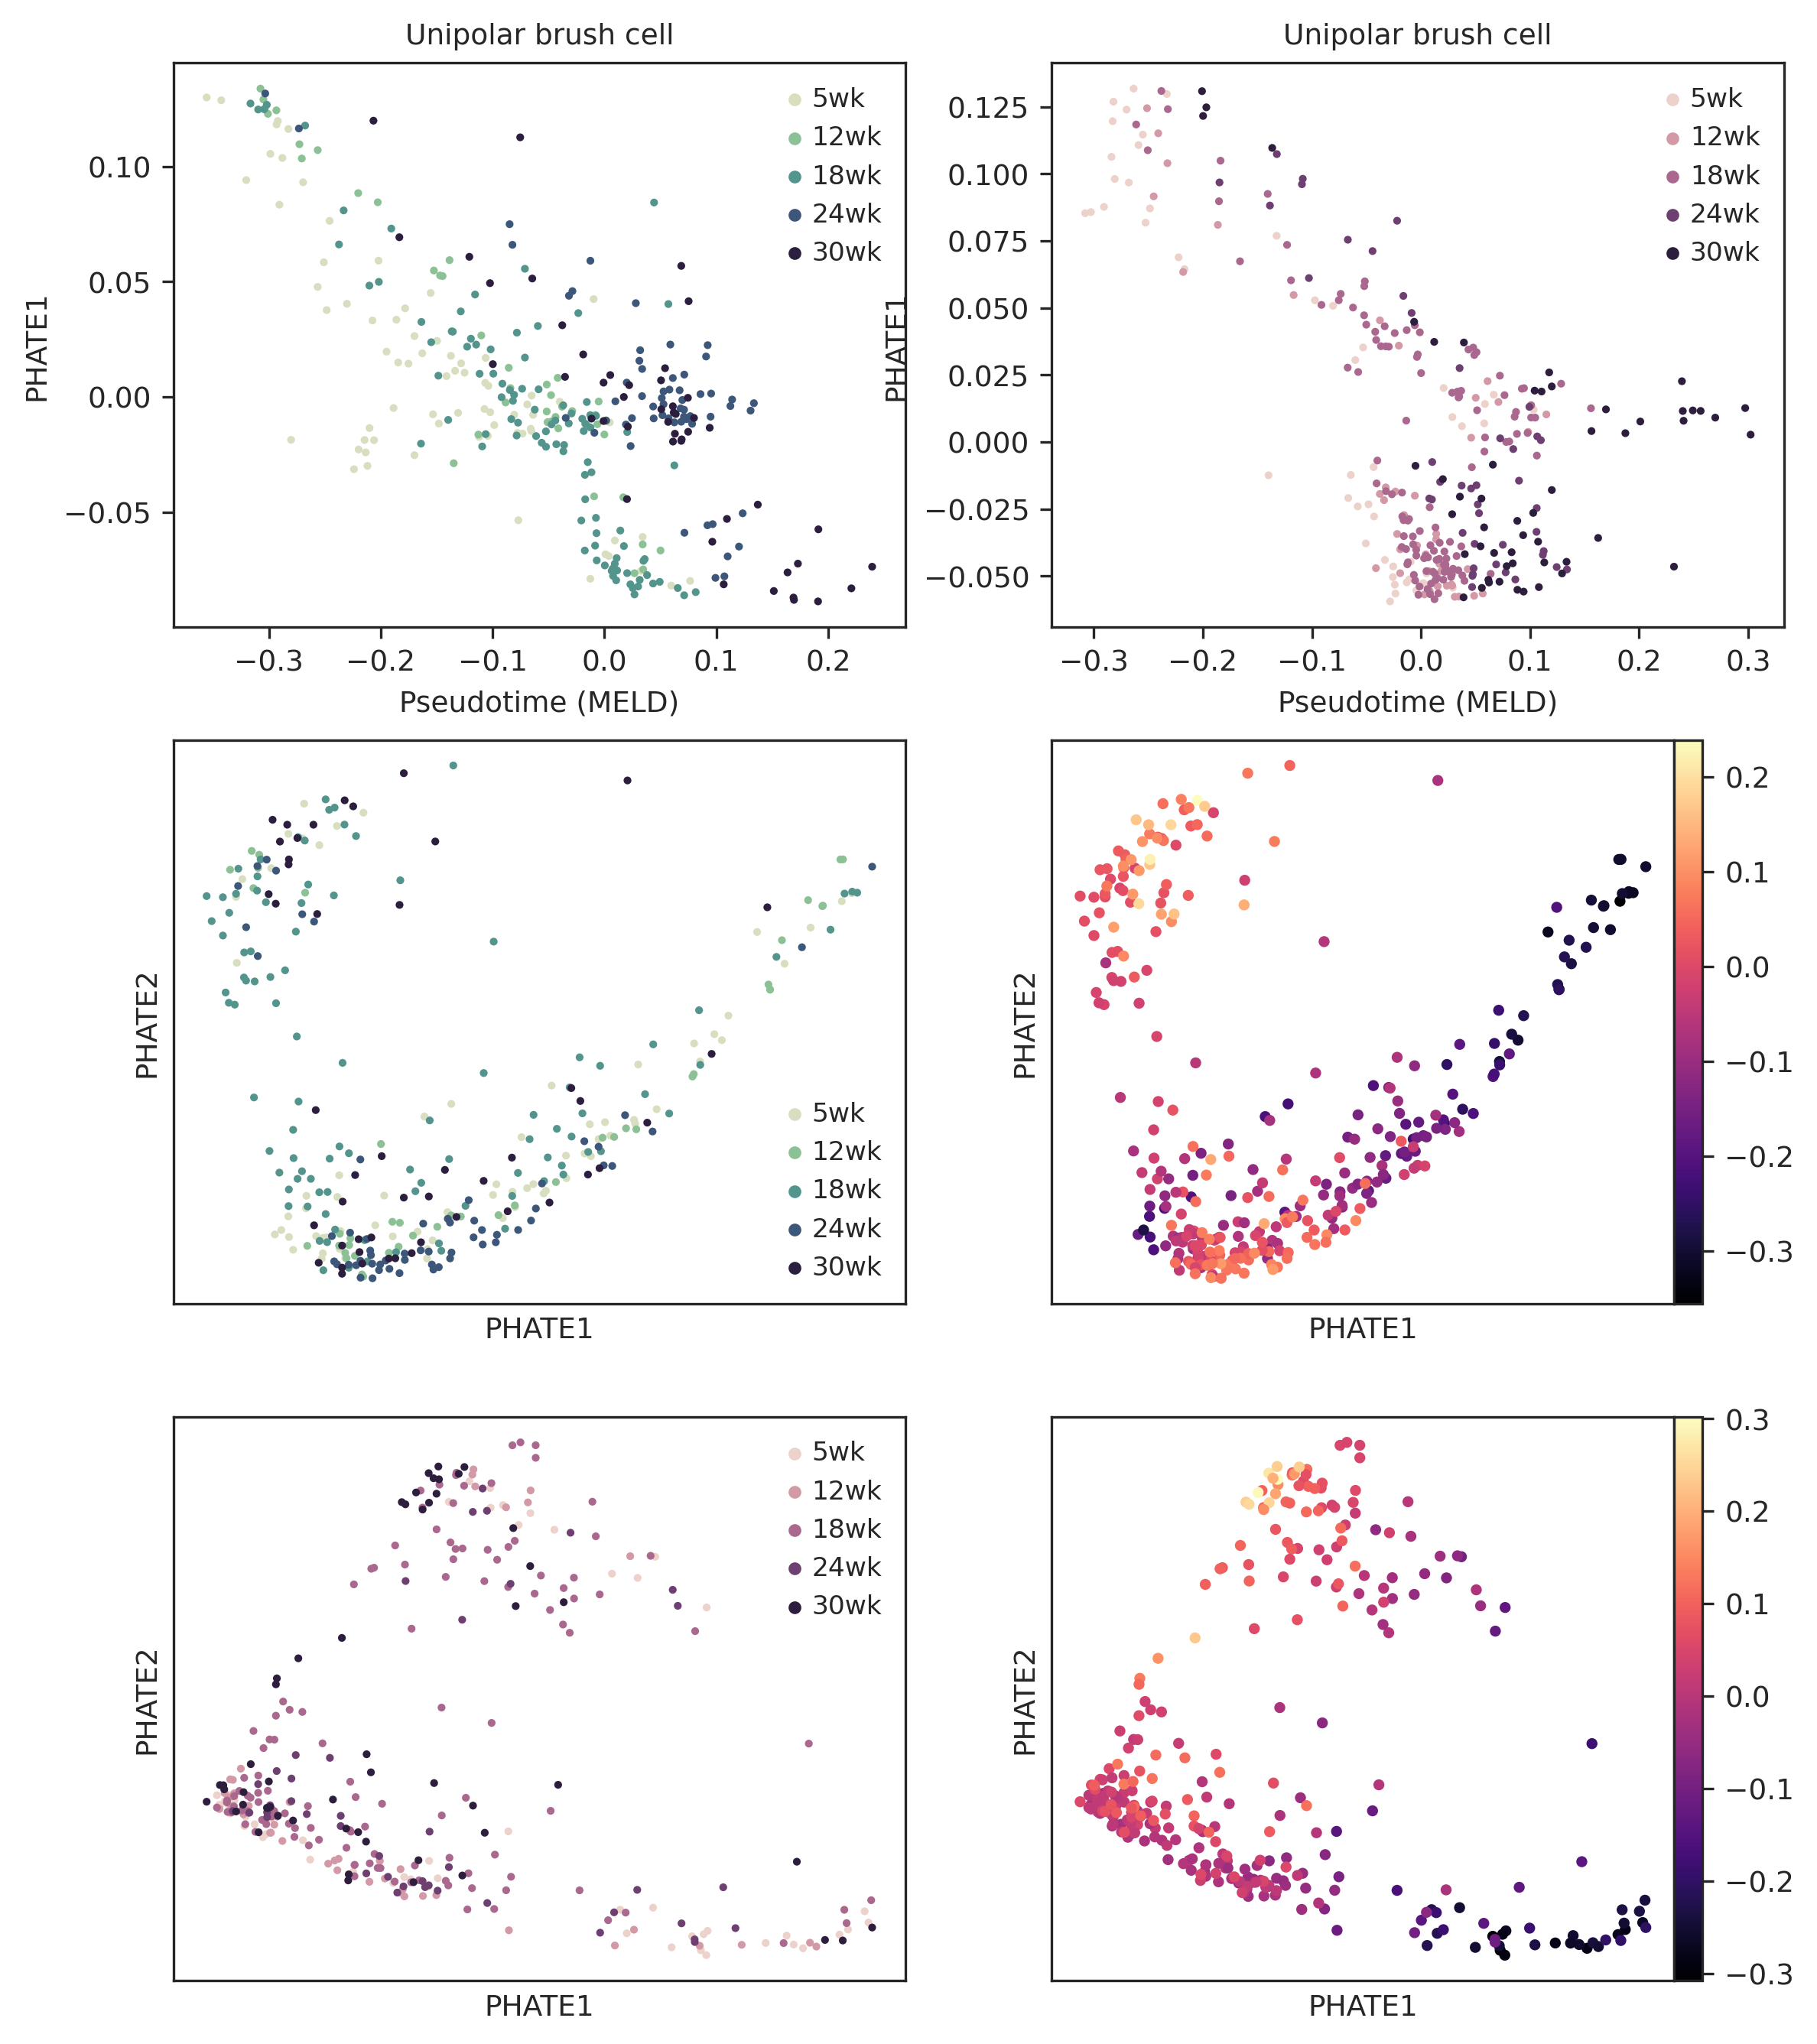

In [10]:
for ctype in ['Deep cerebellar nuclei', 'Unipolar brush cell']:
    wt = adata[(adata.obs['ctype_ubcupdate']==ctype) & (adata.obs['genotype']=='WT')]
    mut = adata[(adata.obs['ctype_ubcupdate']==ctype) & (adata.obs['genotype']=='SCA1')]

    sc.pp.pca(wt)
    sc.pp.neighbors(wt, n_pcs=50)
    sc.pp.pca(mut)
    sc.pp.neighbors(mut, n_pcs=50)

    # MELD
    G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(wt, resolution=3.0)
    sc.tl.umap(wt)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    wt.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    wt.obs['res_t']=-1
    wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
    wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
    wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
    wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
    wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
    G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
    G.knn_max = None
    
    # phate
    sc.tl.leiden(mut, resolution=3.0)
    sc.tl.umap(mut)
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=1,
                           decay=40,
                           n_jobs=-1,
                           t='auto',
                           random_state=42)
    mut.obsm['X_phate'] = phate_op.fit_transform(G.K)
    
    # meld
    mut.obs['res_t']=-1
    mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
    mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
    mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
    mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
    mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])


    # 1d phate
    wt_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(wt.X)
    mut_phate1d = phate.PHATE(knn=15, gamma=0, n_components=1).fit_transform(mut.X)

    # plots 
    fig, ax = plt.subplots(3,2, figsize=(9,11))
    sns.scatterplot(
        x=wt.obsm['X_phate'][:,0],
        y=wt.obsm['X_phate'][:,1],
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[1,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[1,0].set_xlabel('PHATE1')
    ax[1,0].set_ylabel('PHATE2')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    
    p = ax[1,1].scatter(wt.obsm['X_phate'][:,0],
                        wt.obsm['X_phate'][:,1],
                        c=wt.obs['ees_t'],
                        cmap='magma', s=6,
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[1,1])
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    ax[1,1].set_xlabel('PHATE1')
    ax[1,1].set_ylabel('PHATE2')
    
    sns.scatterplot(
        x=mut.obsm['X_phate'][:,0],
        y=mut.obsm['X_phate'][:,1],
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[2,0],
        linewidth=0,
        s=6,
        rasterized=True)
    ax[2,0].set_xlabel('PHATE1')
    ax[2,0].set_ylabel('PHATE2')
    ax[2,0].set_xticks([])
    ax[2,0].set_yticks([])
    
    p = ax[2,1].scatter(mut.obsm['X_phate'][:,0],
                        mut.obsm['X_phate'][:,1],
                        c=mut.obs['ees_t'],
                        cmap='magma', s=6, 
                        rasterized=True)
    fig.colorbar(p, pad=0, ax=ax[2,1])
    ax[2,1].set_xticks([])
    ax[2,1].set_yticks([])
    ax[2,1].set_xlabel('PHATE1')
    ax[2,1].set_ylabel('PHATE2')

    sns.scatterplot(
        x=wt.obs['ees_t'].to_list(),
        y=wt_phate1d.flatten(),
        hue=wt.obs['timepoint'].to_list(),
        palette=cmap_wt,
        ax=ax[0,0],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,0].set_xlabel('Pseudotime (MELD)')
    ax[0,0].set_ylabel('PHATE1')
    ax[0,0].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
        
    sns.scatterplot(
        x=mut.obs['ees_t'].to_list(),
        y=mut_phate1d.flatten(),
        hue=mut.obs['timepoint'].to_list(),
        palette=cmap_mut,
        ax=ax[0,1],
        linewidth=0,
        s=6, 
        rasterized=True)
    ax[0,1].set_xlabel('Pseudotime (MELD)')
    ax[0,1].set_ylabel('PHATE1')
    ax[0,1].set_title(ctype)
    if False:
        # plot smooth line
        z = lowess(phate_1d.flatten(), wt.obs['ees_t'].to_numpy())
        ax[1].plot(z[:,0], z[:,1], 'k-', lw=2)
    
    if True:
        fig.savefig(os.path.join(pfp, 'pseudotime_{}.pdf'.format(ctype)), bbox_inches='tight', dpi=600)
        
    del wt, mut
        
        

# jitter plots

In [13]:
# aesthetics
cmap_wt = {v:sns.cubehelix_palette(8, start=0.5, rot=-0.75)[i+1] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(8)[i+1] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_gt = {}
for k in cmap_wt.keys():
    cmap_gt['WT_{}'.format(k)] = cmap_wt[k]
    cmap_gt['SCA1_{}'.format(k)] = cmap_mut[k]

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


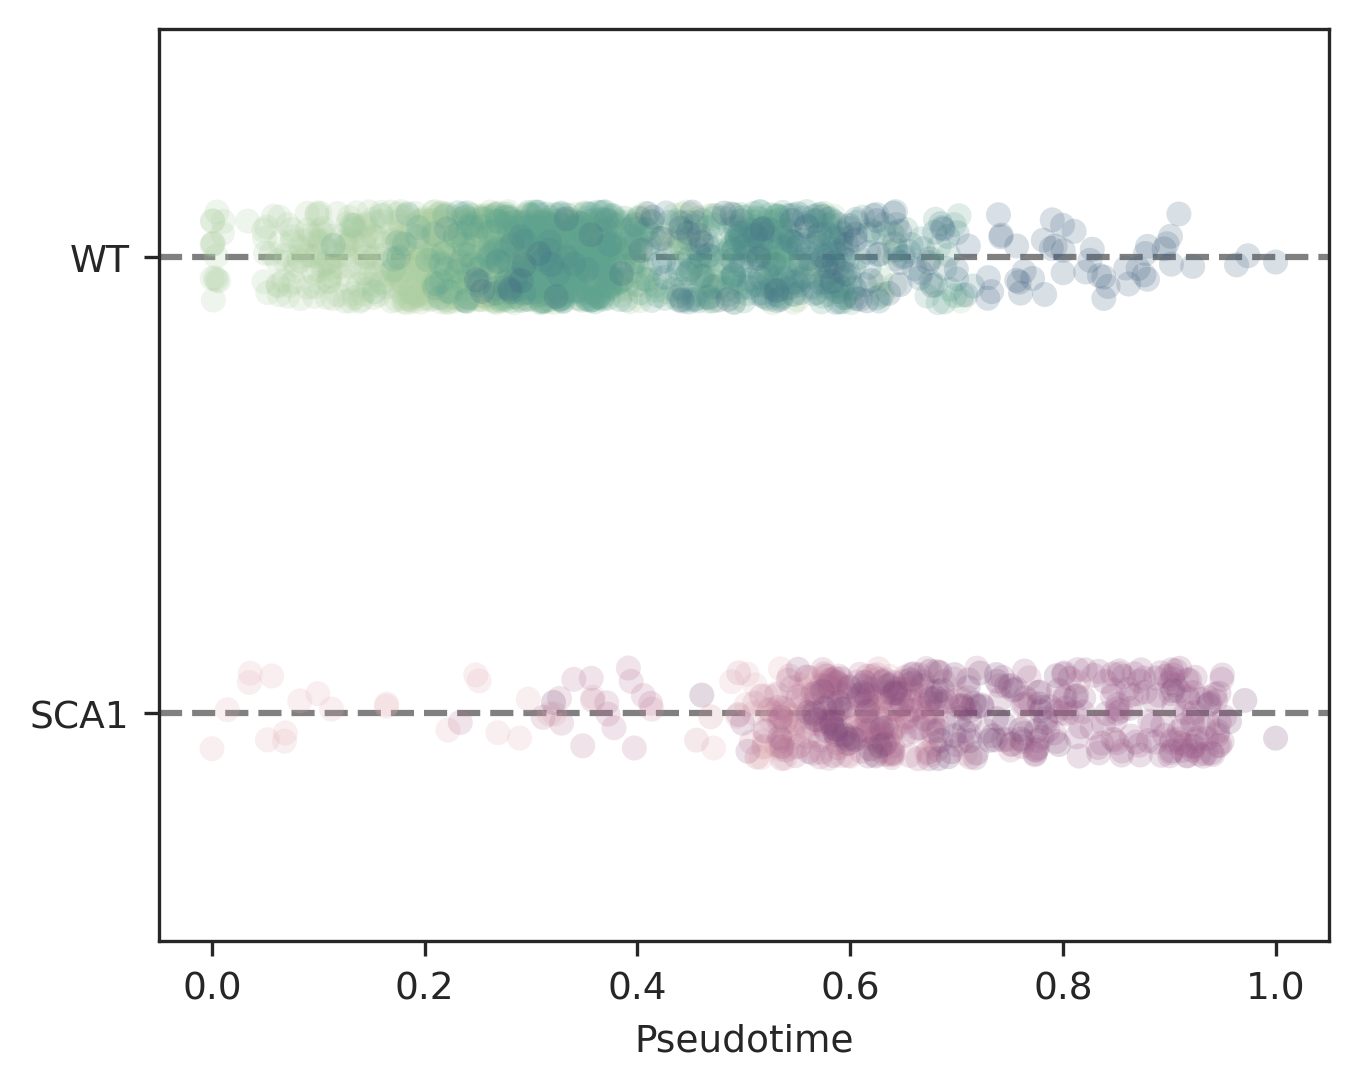

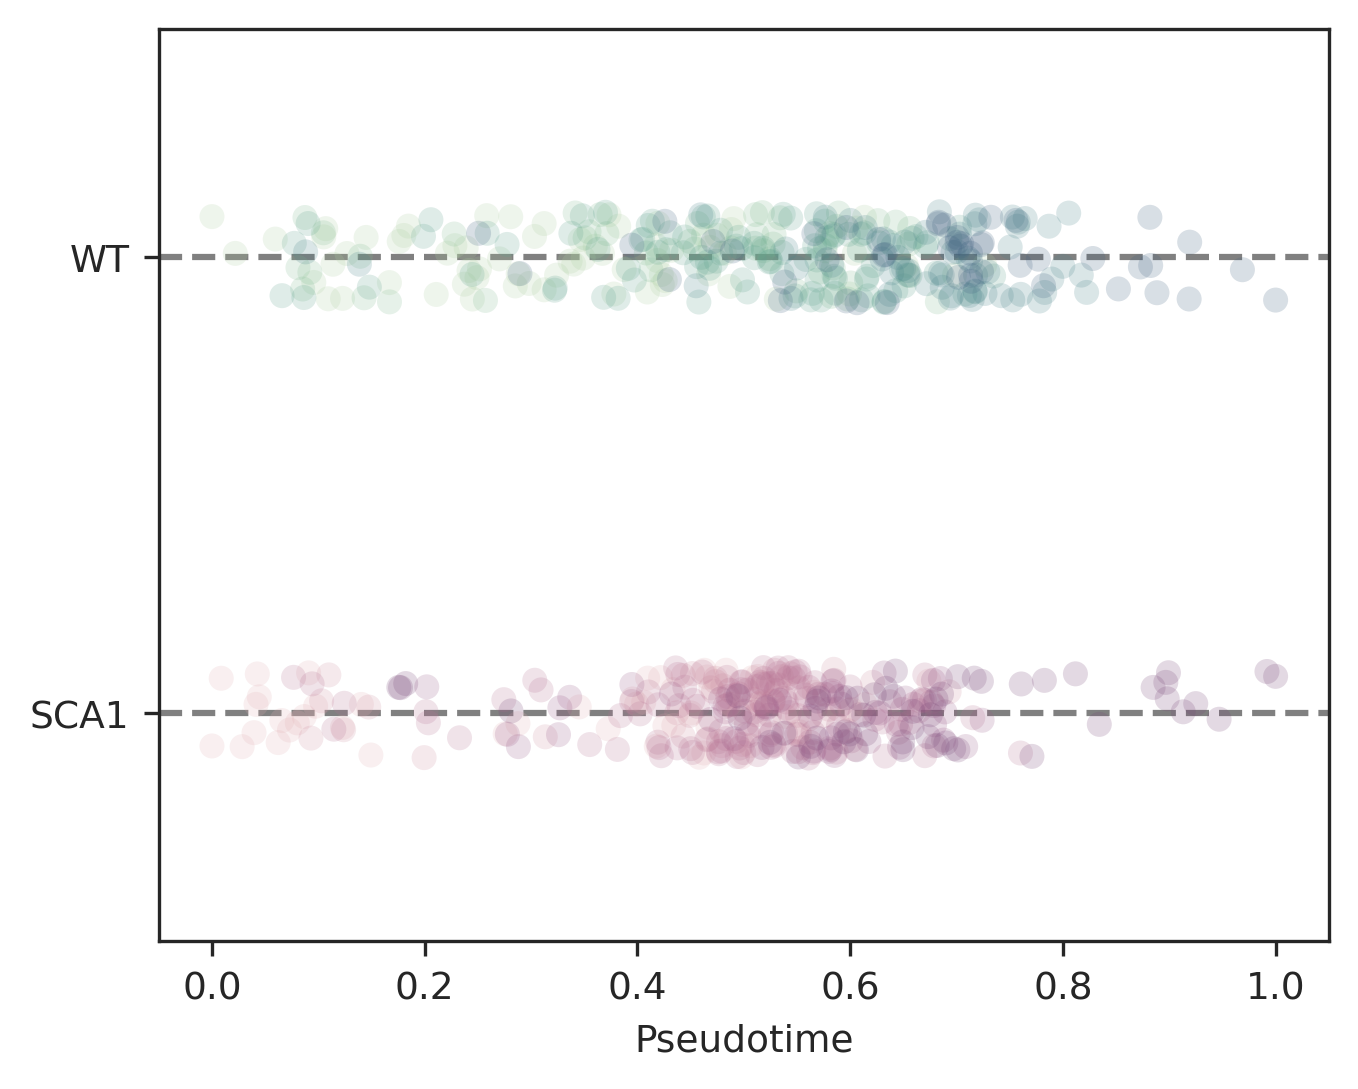

In [14]:
for ctype in ['Deep cerebellar nuclei', 'Unipolar brush cell']:#[i for i in adata.obs['ctype'].unique() if 'Granule' not in i]:
    wt = adata[(adata.obs['ctype_ubcupdate']==ctype) & (adata.obs['genotype']=='WT')]
    mut = adata[(adata.obs['ctype_ubcupdate']==ctype) & (adata.obs['genotype']=='SCA1')]

    sc.pp.pca(wt)
    sc.pp.neighbors(wt, n_pcs=50)
    sc.pp.pca(mut)
    sc.pp.neighbors(mut, n_pcs=50)

    # MELD
    G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    wt.obs['res_t']=-1
    wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
    wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
    wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
    wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
    wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
    wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())
    
    G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
    G.knn_max = None
    mut.obs['res_t']=-1
    mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
    mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
    mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
    mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
    mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
    mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())

    X = pd.DataFrame({'timepoint': wt.obs['timepoint'].to_list(),
                      'genotype': wt.obs['genotype'].to_list(),
                      'Pseudotime': wt.obs['ees_t'].to_list()})
    dt = pd.DataFrame({'timepoint': mut.obs['timepoint'].to_list(),
                      'genotype': mut.obs['genotype'].to_list(),
                      'Pseudotime': mut.obs['ees_t'].to_list()})
    
    X = X.append(dt, ignore_index=True)
    del dt
    
    X['gt'] = X['genotype'] + '_' + X['timepoint']
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    sns.stripplot(
        x='Pseudotime',
        y='genotype',
        hue='gt',
        data=X,
        order=None,
        hue_order=None,
        jitter=True,
        dodge=False,
        orient=None,
        color=None,
        palette=cmap_gt,
        size=6,
        alpha=0.2,
        edgecolor='gray',
        linewidth=0,
        ax=ax,
        rasterized=True
    )
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([xlim[0], xlim[1]], ['WT', 'WT'], color='gray', linestyle='dashed')
    ax.plot([xlim[0], xlim[1]], ['SCA1', 'SCA1'], color='gray', linestyle='dashed')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend().set_visible(False)
    ax.set_ylabel('')
    
    if True:
        fig.savefig(os.path.join(pfp, 'pseudotime1d_{}.pdf'.format(ctype)), bbox_inches='tight', dpi=600)
        
        

# dynamical genes

In [1]:
%matplotlib inline

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/')
from scnd.scripts import data as scnddata
from scnd.scripts import utils as scndutils

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [ ]:
pfp = '/home/ngr4/project/scnd/results'
adata = scnddata.load_mouse_imputed()
wtt = adata[adata.obs['genotype']=='WT', :]#.copy()
mutt = adata[adata.obs['genotype']=='SCA1', :]#.copy()
print(wt)
print('')
print(mut)
del adata

In [ ]:

# get the data
sns.set(font_scale=0.33)
ntop = 100
ntimebins = 20
n_bootstraps = 1 
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell',
                            'Oligodendrocyte', ]):
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # from files 
    topgenes = pd.read_csv(os.path.join(pfp, 'top{}_dyngenes_v3.csv'.format(ntop)), index_col=0)
    wttop = topgenes.loc[((topgenes['ctype']==ctype) & (topgenes['top_wt']==1)), 'index'].to_list()
    muttop = topgenes.loc[((topgenes['ctype']==ctype) & (topgenes['top_mut']==1)), 'index'].to_list()
    topgenes = topgenes.loc[topgenes['ctype']==ctype, 'index'].to_list()

    # topn, specify how to normalize
    norm_ctypeANDcondition = False
    
    if norm_ctypeANDcondition: # plot both for now
        x = pd.DataFrame(wt[:, topgenes].X.todense(), columns=topgenes)
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])
        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}.png'.format(ctype)))

        # plot same genes in mut
        mut_goi = x.index[p.dendrogram_row.reordered_ind].to_list() # in order of previous tree
        x_mut = pd.DataFrame(mut[:, mut_goi].X.todense(), columns=mut_goi)
        x_mut.loc[:, mut_goi] = zscore(x_mut.loc[:, mut_goi])
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}.png'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 14), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}.png'.format(ctype)))
        
    else: # plot both for now
        # topn in WT, standardize in cell type ONLY
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['ctype'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['ctype'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 20),
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}_ctypeNORM.pdf'.format(ctype)))

        # plot same genes in mut
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 20), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}_ctypeNORM.pdf'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 20), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
                vmax=1, vmin=-1,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))
        
        x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
                    x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
                    fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
                    order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
                    y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
                    label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
        fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        fig, ax = plt.subplots(1,1, figsize=(4,3))
        z = x_diff.abs().mean(axis=0).reset_index()
        z = z.rename(columns={0:'ave_mut-wt'})

        # histogram
        sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )
        ax.plot(z['time_grouping']-1, yprime, color='gray')
        ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
        fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

#         x_diff = x_diff.reset_index()
#         x_diff['ctype'] = ctype
#         x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
#         x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val
#         x_diff['wt_importance'] = x_diff['index'].map(wt_score)
#         x_diff['mut_importance'] = x_diff['index'].map(mut_score)

#         results = results.append(x_diff, ignore_index=True)

#         # intermediate save
#         if verbose: # save every round
#             results.to_csv(os.path.join(pfp,'top{}_dyngenes_v3.csv'.format(ntop)))
    
    print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))
    
# results.to_csv(os.path.join(pfp,'top{}_dyngenes_v3.csv'.format(ntop)))

